In [7]:
import pickle as pkl
import numpy as np
import torch
import torch.nn as nn
from torch.nn import NLLLoss
import pandas as pd 

1. Get edgelists as BLANT inputs

In [8]:
# for i in range(2, 50):
#     original_edges = f"../../graphs/tx_graph/tx_transaction_graph_timestamp_{i}.pkl"

#     G = pkl.load(open(original_edges, "rb"))
#     np.savetxt(f"edgelists/tx_transaction_graph_timestamp_{i}.el", list(G.edges()), fmt="%d")

2. Graphlet preprocessing

In [9]:
# Gs = []
# graphlets_list = []
# for i in range(1, 50):
#     Gs.append(pkl.load(open(f"../../graphs/tx_graph/tx_transaction_graph_timestamp_{i}.pkl", "rb")))
#     graphlets = np.loadtxt(f"graphlets/tx_{i}_dedup_6.graphlets", dtype=int)
#     graphlets_list.append(graphlets)

In [18]:
G1 = pkl.load(open(f"../../graphs/tx_graph/tx_transaction_graph_timestamp_1.pkl", "rb"))
graphlets1 = np.loadtxt(f"graphlets/tx_1_dedup_6.graphlets", dtype=int)

G2 = pkl.load(open(f"../../graphs/tx_graph/tx_transaction_graph_timestamp_5.pkl", "rb"))
graphlets2 = np.loadtxt(f"graphlets/tx_5_dedup_6.graphlets", dtype=int)
G2 = pkl.load(open(f"../../graphs/tx_graph/tx_transaction_graph_timestamp_5.pkl", "rb"))
graphlets2 = np.loadtxt(f"graphlets/tx_5_dedup_6.graphlets", dtype=int)

G3 = pkl.load(open(f"../../graphs/tx_graph/tx_transaction_graph_timestamp_2.pkl", "rb"))
graphlets3 = np.loadtxt(f"graphlets/tx_2_dedup_6.graphlets", dtype=int)

In [19]:
ids1, graphlets1 = graphlets1[:, 0], graphlets1[:, 1:]  # Do this after getting unique graphlets to account for orbits
ids2, graphlets2 = graphlets2[:, 0], graphlets2[:, 1:]  # Do this after getting unique graphlets to account for orbits
ids3, graphlets3 = graphlets3[:, 0], graphlets3[:, 1:]  # Do this after getting unique graphlets to account for orbits

In [20]:
len(set(ids1)), len(set(ids2)), len(set(ids3))

(105, 112, 111)

In [21]:
len(graphlets1), len(graphlets2), len(graphlets3)

(3349993, 3687679, 2148325)

In [10]:
from importlib import reload
import graphlet_dataset  # the module, not the class
import random

# random.shuffle(graphlets2)

train_graphlets = graphlets1
val_graphlets = graphlets3
test_graphlets = graphlets2  # Make test set the same size as train set for balanced eval
val_graphlets = graphlets3
test_graphlets = graphlets2  # Make test set the same size as train set for balanced eval

# Reload the module
reload(graphlet_dataset)

<module 'graphlet_dataset' from 'c:\\Users\\sebas\\Desktop\\repos\\MLG\\Project\\src\\jupyter\\graphlet_dataset.py'>

In [23]:
def get_single_graphlet_label(graphlet,G ):
    node_classes = [G.nodes[n].get("class", 3) - 1 for n in graphlet]
    if 0 in node_classes: 
        return 0
    return max(set(node_classes), key=node_classes.count)

In [24]:
val_labels = [get_single_graphlet_label(g, G3) for g in val_graphlets]
test_labels = [get_single_graphlet_label(g, G2) for g in test_graphlets]
val_labels = [get_single_graphlet_label(g, G3) for g in val_graphlets]
test_labels = [get_single_graphlet_label(g, G2) for g in test_graphlets]
train_labels = [get_single_graphlet_label(g, G1) for g in train_graphlets]

from collections import Counter
Counter(val_labels), Counter(test_labels), Counter(train_labels)

(Counter({2.0: 1434150, 1.0: 638766, 0: 75409}),
 Counter({2.0: 2805656, 1.0: 868857, 0: 13166}),
 Counter({2.0: 1835456, 1.0: 1473413, 0: 41124}))

In [25]:
# val_test   = set(tuple(sorted(g)) for g in val_graphlets)
# test_test  = set(tuple(sorted(g)) for g in test_graphlets)
# train_test = set(tuple(sorted(g)) for g in train_graphlets)

# print("Val vs Test overlap:", len(val_test & test_test))
# print("Train vs Val overlap:", len(train_test & val_test))
# print("Train vs Test overlap:", len(train_test & test_test))


## Loading datasets from disk

In [14]:
# train_dataset = graphlet_dataset.GraphletDataset(train_graphlets, G1, labeled_only=True)
# train_dataset.save_dataset("graphlet_datasets/tx_graphlet_train_dataset.pt")

# val_dataset = graphlet_dataset.GraphletDataset(val_graphlets, G3, labeled_only=True)
# val_dataset.save_dataset("graphlet_datasets/tx_graphlet_val_dataset.pt")

# test_dataset = graphlet_dataset.GraphletDataset(test_graphlets, G2, labeled_only=True)
# test_dataset.save_dataset("graphlet_datasets/tx_graphlet_test_dataset.pt")

['Time step', 'Local_feature_1', 'Local_feature_2', 'Local_feature_3', 'Local_feature_4', 'Local_feature_5', 'Local_feature_6', 'Local_feature_7', 'Local_feature_8', 'Local_feature_9', 'Local_feature_10', 'Local_feature_11', 'Local_feature_12', 'Local_feature_13', 'Local_feature_14', 'Local_feature_15', 'Local_feature_16', 'Local_feature_17', 'Local_feature_18', 'Local_feature_19', 'Local_feature_20', 'Local_feature_21', 'Local_feature_22', 'Local_feature_23', 'Local_feature_24', 'Local_feature_25', 'Local_feature_26', 'Local_feature_27', 'Local_feature_28', 'Local_feature_29', 'Local_feature_30', 'Local_feature_31', 'Local_feature_32', 'Local_feature_33', 'Local_feature_34', 'Local_feature_35', 'Local_feature_36', 'Local_feature_37', 'Local_feature_38', 'Local_feature_39', 'Local_feature_40', 'Local_feature_41', 'Local_feature_42', 'Local_feature_43', 'Local_feature_44', 'Local_feature_45', 'Local_feature_46', 'Local_feature_47', 'Local_feature_48', 'Local_feature_49', 'Local_feature_

torch.__version__

In [15]:
train_dataset = graphlet_dataset.load_dataset("graphlet_datasets/tx_graphlet_train_dataset.pt")
val_dataset = graphlet_dataset.load_dataset("graphlet_datasets/tx_graphlet_val_dataset.pt")
test_dataset = graphlet_dataset.load_dataset("graphlet_datasets/tx_graphlet_test_dataset.pt")
train_dataset = graphlet_dataset.load_dataset("graphlet_datasets/tx_graphlet_train_dataset.pt")
val_dataset = graphlet_dataset.load_dataset("graphlet_datasets/tx_graphlet_val_dataset.pt")
test_dataset = graphlet_dataset.load_dataset("graphlet_datasets/tx_graphlet_test_dataset.pt")

In [16]:
len(train_dataset), len(val_dataset), len(test_dataset)

(1514537, 227337, 882023)

In [17]:
train_dataset.get_label_distribution(), val_dataset.get_label_distribution(), test_dataset.get_label_distribution()

({0: 41124, 1: 1473413}, {0: 8900, 1: 218437}, {0: 13166, 1: 868857})

In [18]:
from torch_geometric.loader import DataLoader

val_loader = DataLoader(val_dataset, batch_size=16384*32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16384*32, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=16384*32, shuffle=True)

### Training

In [19]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout):
        super(GCN, self).__init__()
        self.count = 0
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers):
            if i == 0:
                self.convs.append(GCNConv(input_dim, hidden_dim))
            elif i == num_layers - 1:
                self.convs.append(GCNConv(hidden_dim, output_dim))
            else:
                self.convs.append(GCNConv(hidden_dim, hidden_dim))
        # self.convs.append(GCNConv(hidden_dim, 6))

        self.lns = torch.nn.ModuleList([torch.nn.LayerNorm(hidden_dim) for _ in range(num_layers - 1)])
        self.softmax = torch.nn.LogSoftmax(dim=1)
        self.dropout = dropout

    def forward(self, x, adj_t):
        if torch.isnan(x).any():
            print(f"NaN in conv output layer: {self.count}")
        for i in range(len(self.convs)):
            x = self.convs[i](x, adj_t)
            if torch.isnan(x).any():
                print(f"NaN in conv output layer: {self.count}")
            self.count += 1

            # print("After Conv:")
            # print(x)
            if i < len(self.lns):
                x = self.lns[i](x)
                # print("After norm:")
                # print(x)
                x = torch.nn.functional.relu(x)
                # print("After RELU:")
                # print(x)
                x = torch.nn.functional.dropout(x, self.dropout, training=self.training)
                # print(x)
        # x = self.convs[-1](x, adj_t)
        return x

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
from torch_geometric.nn import global_mean_pool
# from torch_scatter import scatter_mean  

def train(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    count = 0

    for batch in loader:
        batch.x, batch.edge_index, batch.y, batch.batch = batch.x.to(device), batch.edge_index.to(device), batch.y.to(device), batch.batch.to(device)
        optimizer.zero_grad()
        
        out = model(batch.x, batch.edge_index)
        graphlet_out = global_mean_pool(out, batch.batch)
        # graphlet_out = scatter_mean(out, batch.batch, dim=0)

        y = batch.y

        # mask = y != 2

        # if mask.sum() == 0:   # skip empty batch
        #     continue

        # #Need to remap this to work with nll ?loss. Now 0 is illicit and 1 is licit.
        # y_remapped = (y[mask]).long()
        

        preds = torch.log_softmax(graphlet_out, dim=1)
        # print(out[mask][:5], y_remapped[:5])
        loss = loss_fn(preds, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        count += 1
        
        # print(f"Batch {count}, Loss: {loss.item()}")
    # print(count, total_loss)
    return total_loss / max(count, 1)

In [36]:
from sklearn.metrics import f1_score, precision_score, recall_score

@torch.no_grad()
def test(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    count = 0

    all_predictions = []
    all_y = []

    for batch in loader:
        batch.x, batch.edge_index, batch.y, batch.batch = batch.x.to(device), batch.edge_index.to(device), batch.y.to(device), batch.batch.to(device)

        # Node-level output
        out = model(batch.x, batch.edge_index)

        # Graphlet-level output
        graphlet_out = global_mean_pool(out, batch.batch)
        
        # graphlet_out = scatter_mean(out, batch.batch, dim=0)  # [num_graphlets, num_classes]
        y = batch.y  # graphlet labels

        # Only compute loss on labeled graphlets
        mask = (y != 2)
        if mask.sum() == 0:
            continue

        y_remapped = y[mask].long()  # if needed, adjust mapping

        masked_out = graphlet_out[mask]
        predicted_classes = masked_out.argmax(dim=1)

        all_predictions.extend(predicted_classes.cpu().tolist())
        all_y.extend(y_remapped.cpu().tolist())


        total_loss += loss_fn(masked_out, y_remapped).item()
        count += 1
    # print("Weighted f1:", f1_score(all_y, all_predictions, average="weighted", zero_division=0), 
    #       "Precision:", precision_score(all_y, all_predictions, average="weighted", zero_division=0),
        #   "Recall:", recall_score(all_y, all_predictions, average="weighted"), zero_division=0)
    print("f1:", f1_score(all_y, all_predictions, average=None, pos_label=0, zero_division=0), 
          "Precision:", precision_score(all_y, all_predictions, average=None, pos_label=0, zero_division=0),
          "Recall:", recall_score(all_y, all_predictions, average=None, pos_label=0, zero_division=0))
    print(all_predictions.count(0), "vs", all_y.count(0), "|", all_predictions.count(1), "vs", all_y.count(1))
    return f1_score(all_y, all_predictions, pos_label=0, zero_division=0), total_loss / max(count, 1)

In [44]:
args = {
      'device': device,
      'num_layers': 3,
      'hidden_dim': 64,
      'dropout': 0.2,
      'lr': 0.001,
      'epochs': 100,
  }

In [45]:
dist = list(train_dataset.get_label_distribution().items())
w_ilicit = dist[0][1] / (dist[0][1] + dist[1][1])
w_licit = dist[1][1] / (dist[0][1] + dist[1][1])
class_weights = torch.tensor([w_ilicit, w_licit][::-1], device=device)
class_weights

tensor([0.9728, 0.0272], device='cuda:0')

In [46]:
np.random.seed(42)
torch.manual_seed(42)
model = GCN(183, #hardcoded for now
            args["hidden_dim"],
            2,   #hardcoded for now
            args["num_layers"],
            args["dropout"]
            ).to(args["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])


loss_fn = NLLLoss(weight=class_weights)

In [47]:
device

device(type='cuda')

In [48]:
model = model.to(device)

In [49]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
torch.manual_seed(42)

min_val_loss = float('inf')
test_losses = []
val_losses = []

for epoch in range(args["epochs"]):
    train_result = train(model, train_loader, optimizer, loss_fn)
    val_f1, val_loss = test(model, val_loader, loss_fn)

    test_losses.append(train_result)
    val_losses.append(val_loss)
    
    # if epoch % 10 == 0:
    print(f"Epoch: {epoch+1}/{args['epochs']} | Train loss: {train_result} | Validation f1: {val_f1} | Validation loss: {val_loss}")
    print("-------------------------------------------------------------------------------------------------------------------------")
    
    if val_loss < min_val_loss:
        torch.save(model.state_dict(), "best_graphlet_model.pth")
        min_val_loss = val_loss

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000183046238E0>>
Traceback (most recent call last):
  File "c:\Users\sebas\one\OneDrive\grive\faks\masters\y2\s1\MLG\MLG\Project\.venv\lib\site-packages\ipykernel\ipkernel.py", line 797, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


f1: [0.0926216  0.37328812] Precision: [0.04864147 0.99409807] Recall: [0.96651685 0.22978708]
176845 vs 8900 | 50492 vs 218437
Epoch: 1/30 | Train loss: 0.31738621561277297 | Validation f1: 0.0926216048884223 | Validation loss: -2.9496797834123885
-------------------------------------------------------------------------------------------------------------------------


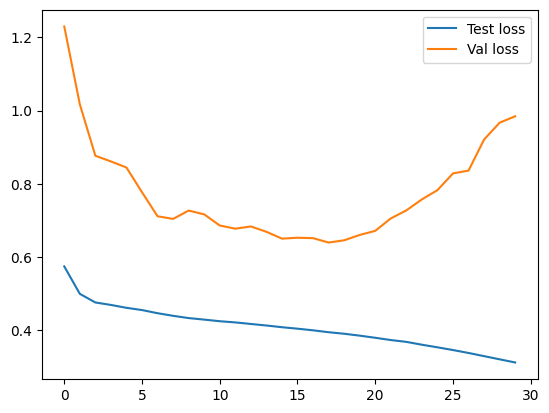

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=range(len(test_losses)), y=test_losses, label="Test loss")
sns.lineplot(x=range(len(test_losses)), y=val_losses, label="Val loss")
plt.legend()

In [48]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
import torch

@torch.no_grad()
def test_more_metrics(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    count = 0

    all_predictions = []
    all_y = []
    all_probs = []  # for ROC-AUC

    for batch in loader:
        batch.x, batch.edge_index, batch.y, batch.batch = \
            batch.x.to(device), batch.edge_index.to(device), batch.y.to(device), batch.batch.to(device)

        # Node-level output
        out = model(batch.x, batch.edge_index)

        # Graphlet-level output
        graphlet_out = global_mean_pool(out, batch.batch)  # [num_graphlets, num_classes]
        y = batch.y  # graphlet labels

        # Only compute loss on labeled graphlets
        mask = (y != 2)
        if mask.sum() == 0:
            continue

        y_remapped = y[mask].long()
        masked_out = graphlet_out[mask]

        probs = torch.softmax(masked_out, dim=1)  # probabilities
        predicted_classes = masked_out.argmax(dim=1)

        all_predictions.extend(predicted_classes.cpu().tolist())
        all_y.extend(y_remapped.cpu().tolist())
        all_probs.extend(probs.cpu().tolist())

        total_loss += loss_fn(masked_out, y_remapped).item()
        count += 1

    # Convert to tensors/numpy for sklearn
    import numpy as np
    all_y = np.array(all_y)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    # Metrics
    f1 = f1_score(all_y, all_predictions, average=None, zero_division=0)
    precision = precision_score(all_y, all_predictions, average=None, zero_division=0)
    recall = recall_score(all_y, all_predictions, average=None, zero_division=0)
    accuracy = accuracy_score(all_y, all_predictions)

    # ROC-AUC (only works for binary)
    if all_probs.shape[1] == 2:
        roc_auc = roc_auc_score(all_y, all_probs[:,0])  # positive class = 0
    else:
        roc_auc = None

    print("F1:", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Accuracy:", accuracy)
    if roc_auc is not None:
        print("ROC-AUC:", roc_auc)

    print(all_predictions.tolist().count(0), "vs", all_y.tolist().count(0),
          "|", all_predictions.tolist().count(1), "vs", all_y.tolist().count(1))

    return f1, accuracy, roc_auc, total_loss / max(count, 1)


In [49]:
test(model, test_loader, loss_fn)

f1: [0.11973439 0.93399967] Precision: [0.06704104 0.99248851] Recall: [0.55947137 0.88202086]
109873 vs 13166 | 772150 vs 868857


(0.11973439315989239, -0.016585351899266243)

In [50]:
test_more_metrics(model, test_loader, loss_fn)

F1: [0.11973439 0.93399967]
Precision: [0.06704104 0.99248851]
Recall: [0.55947137 0.88202086]
Accuracy: 0.8772061499530057
ROC-AUC: 0.21144207457754247
109873 vs 13166 | 772150 vs 868857


(array([0.11973439, 0.93399967]),
 0.8772061499530057,
 0.21144207457754247,
 -0.016585348173975945)

In [51]:
len(test_dataset), len(train_dataset)

(882023, 1514537)

Test new vs old GraphletDataset

In [52]:
# from torch_geometric.utils import to_networkx

# test_old = graphlet_dataset.load_dataset("graphlet_datasets/tx_graphlet_test_dataset.pt")
# test_dataset = graphlet_dataset.load_dataset("graphlet_datasets/tx_graphlet_test_dataset_new.pt")

# for i in range(len(test_old.data_list)):
#     d1 = test_old.data_list[0]
#     d2 = test_dataset.data_list[0]

#     d1_ = to_networkx(d1)
#     d2_ = to_networkx(d2)
#     if not nx.is_isomorphic(d1_, d2_):
#         print("Not isomorphic")
    